In [8]:
import sys
sys.path.append("..")
from matplotlib import cm
import numpy as np
import itertools
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
from src import model

# cancer_type = "luad"
# log_theta_file = "luad_mixed_20_8_0035"
# event_file = "G13_LUAD_PM_z1_Events_20and8_Full"

cancer_type = "paad"
log_theta_file = "paad_mixed_08_003"
event_file = "G12_PAADPANET_PM_z10_Events_30and5_Full"

# TODO Clean this up! What is happening here?
events = pd.read_csv(f"../data/{cancer_type}/{event_file}.csv", index_col=0)

# for paad, we leave out some patients without subtype info
events = events.drop(index=["GENIE-MSK-P-0032535",
                     "GENIE-MSK-P-0040152", "GENIE-MSK-P-0058157"])
log_theta = pd.read_csv(f"../results/{cancer_type}/{log_theta_file}.csv", index_col=0)
tau1, tau2 = np.exp(log_theta["Sampling"][:2])
log_theta.drop(columns="Sampling", inplace=True)
metMHN = model.MetMHN(log_theta=np.array(log_theta),
                      tau1=tau1, tau2=tau2, events=log_theta.columns)
n = log_theta.shape[0] - 1

# met_info = pd.read_csv(f"../data/{cancer_type}/G13_LUAD_PM_z1_sampleSelection_20and8.csv").set_index("patientID")
met_info = pd.read_table(f"../data/{cancer_type}/sampleSelection.txt").set_index("patientID")

events = events.join(met_info["metaStatus"]).drop(
    columns=["P.AgeAtSeqRep", "M.AgeAtSeqRep"])
# PTs with unknown metaStatus were left out at training
events = events.drop(events[events["metaStatus"] == "unknown"].index)
events["Seeding"] = (events["metaStatus"] != "absent").astype(int)

mets_t1 = events[events["metaStatus"] == "isMetastasis"].drop(
    columns=[c for c in events.columns if c.startswith("P.") or c in ["paired", "metaStatus"]]).astype(int)
mets_t2 = events[events["metaStatus"] == "isPaired"].drop(
    columns=[c for c in events.columns if c.startswith("P.") or c in ["paired", "metaStatus"]]).astype(int)
pts = events[events["metaStatus"] != "isMetastasis"].drop(
    columns=[c for c in events.columns if c.startswith("M.") or c in ["paired", "metaStatus"]]).astype(int)


In [9]:
pt_orders = [tuple(metMHN.likeliest_order(row, tau=1)[1])
             for _, row in pts.iterrows()]
met_orders = [tuple(metMHN.likeliest_order(row, tau=1)[1])
              for _, row in mets_t1.iterrows()]

### Order Trees

In [10]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])


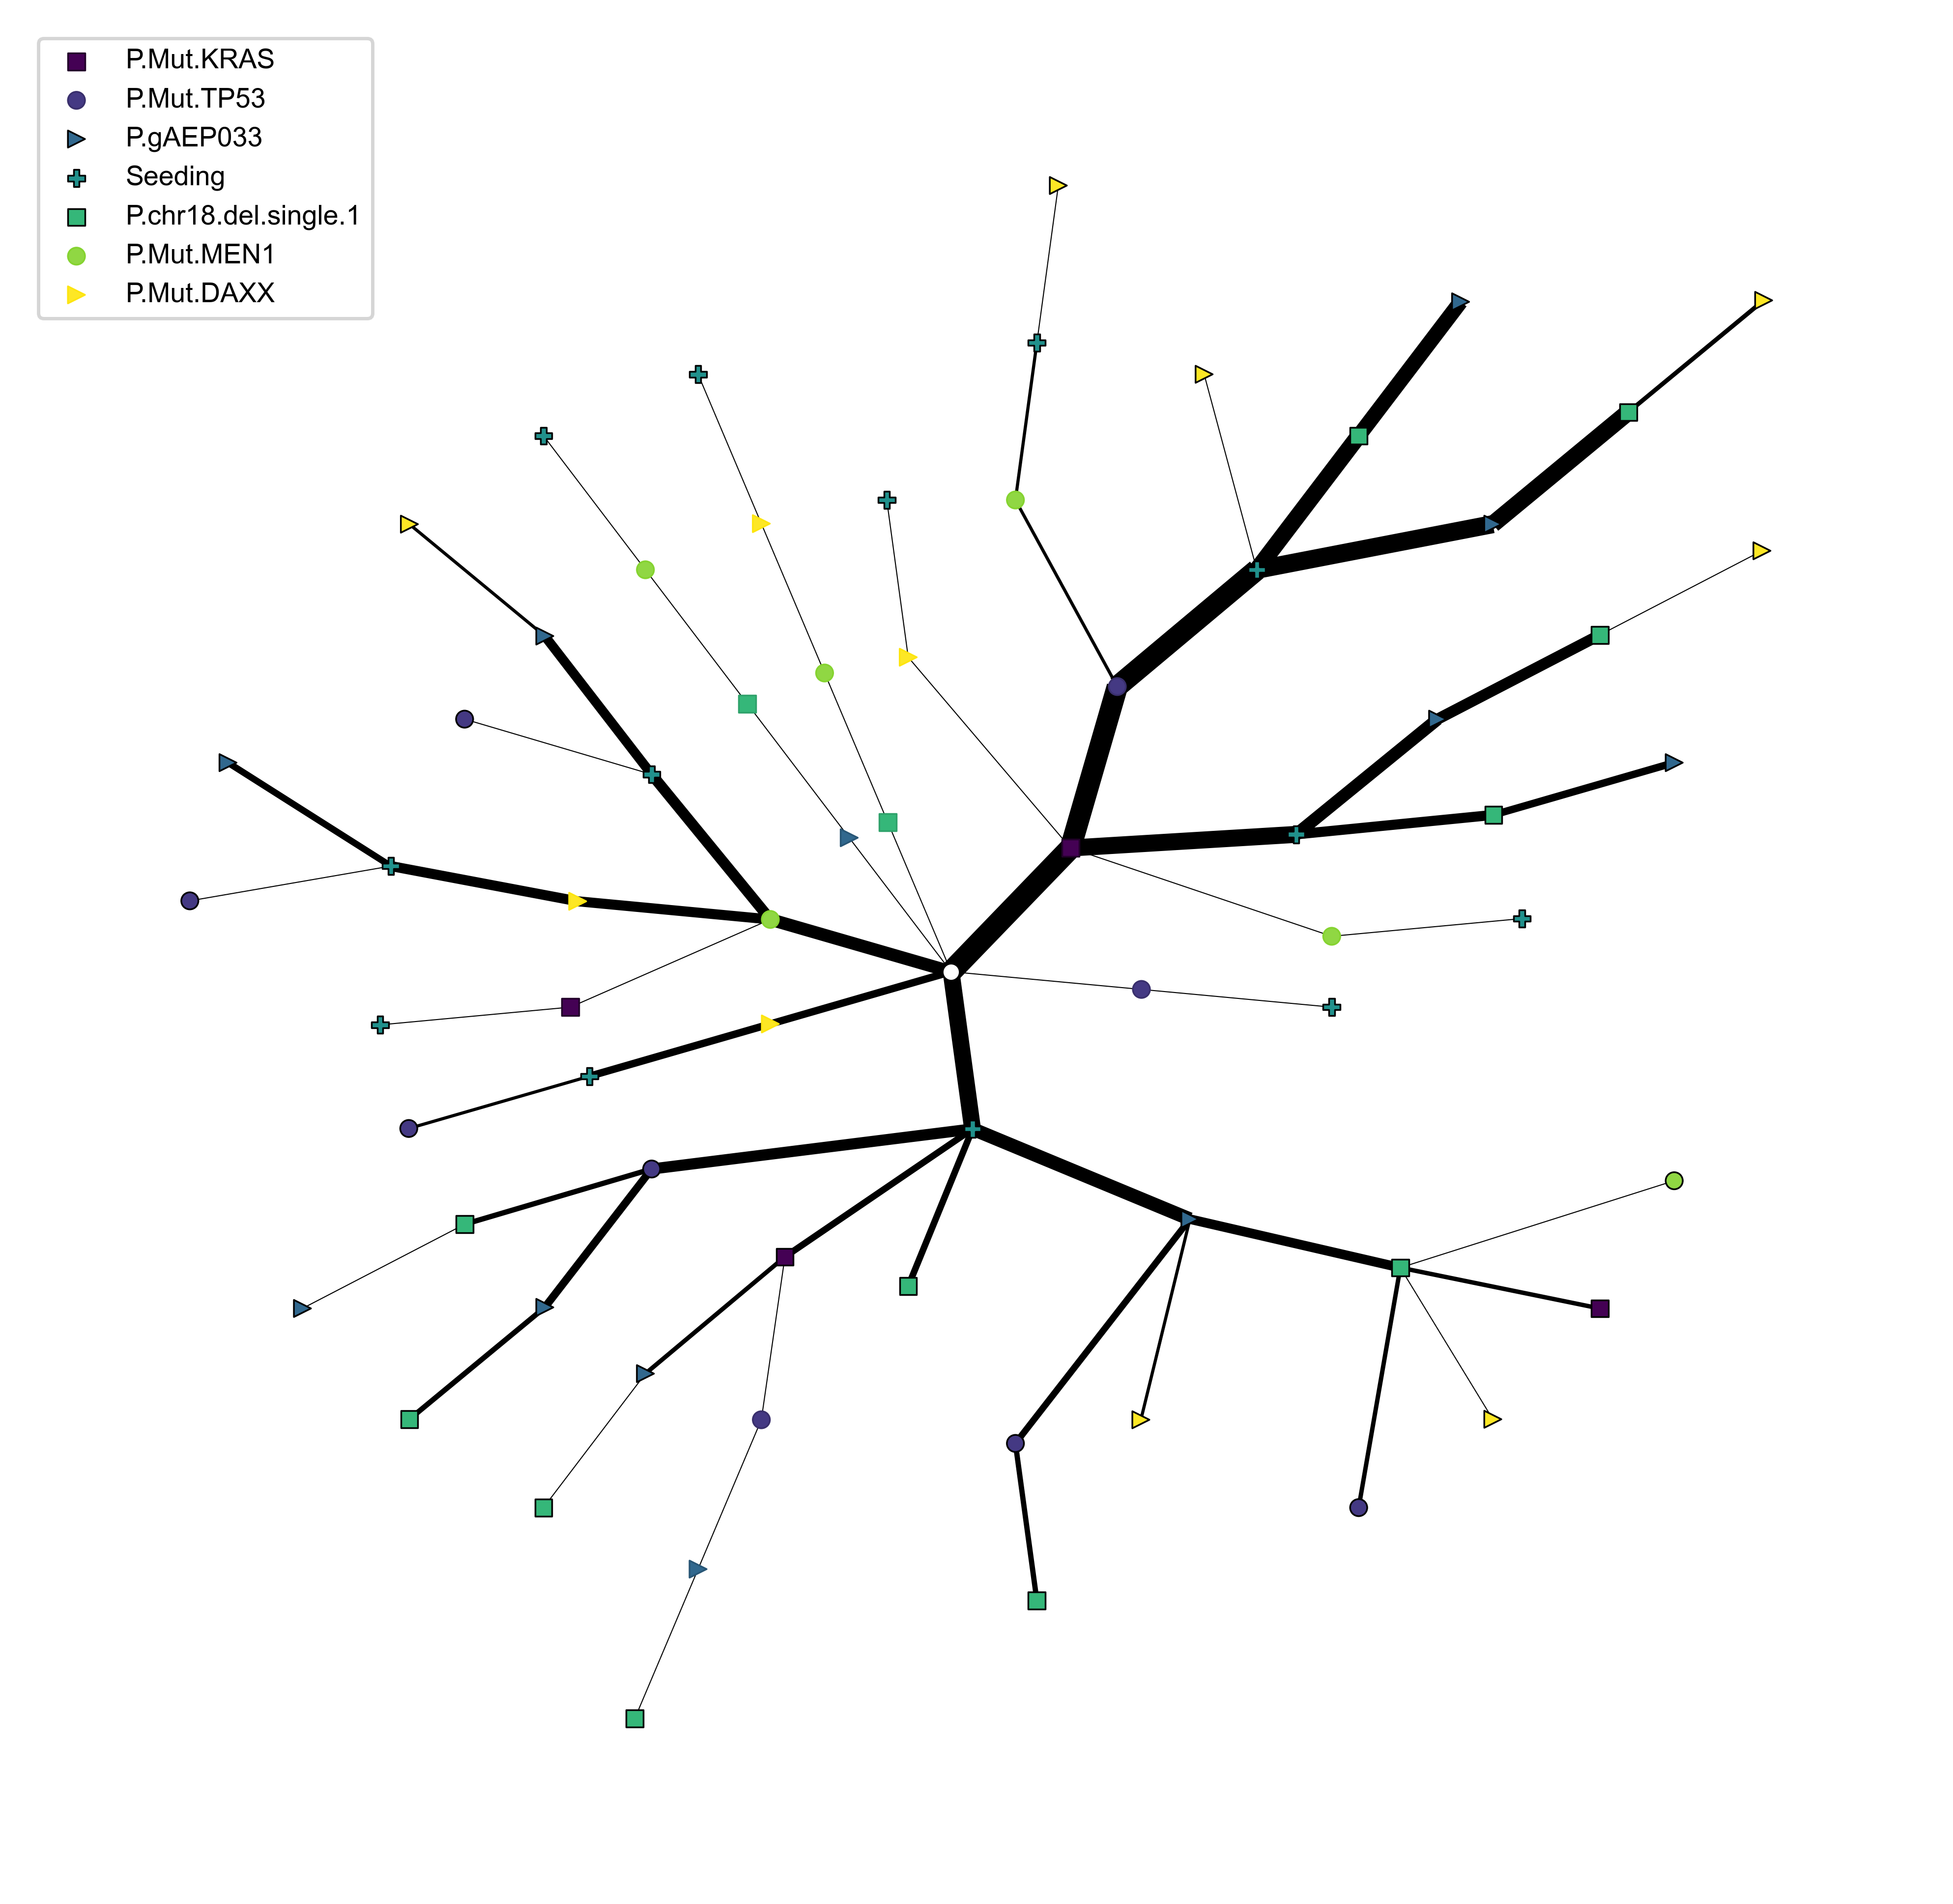

In [18]:
my_orders = met_orders #+ pt_orders
f, axis = plt.subplots()
legend_alias = {i: e for i, e in enumerate(metMHN.events)}
markers = ["s", "o", ">", "P"]
cmap = cm.viridis
node_size = 25
contour_width = 0.5
always_contour = False
root = ()
legend_kws = {"size": 8, "family": "Arial"}
colors = None

importance = np.abs(metMHN.log_theta - np.diag(np.diag(metMHN.log_theta)))
importance = importance.sum(axis=0) + importance.sum(axis=1)
filtered_events = np.arange(metMHN.log_theta.shape[0])[
    np.argsort(importance)[:28:-1]]
    # np.argsort(importance)]
my_orders = [tuple(event for event in o if event in filtered_events)
             for o in my_orders]
my_orders = [o for o in my_orders if not o == ()]

g = metMHN.history_tree(my_orders)

if isinstance(markers, list):
    markers = {n: m for n, m in zip(
        g.graph["observations"], itertools.cycle(markers))}

if colors is None:
    colors = {n: cmap(i)
              for n, i in zip(
                  g.graph["observations"], np.linspace(0, 1, len(g.graph["observations"])))}


labels_to_int = {}
int_to_labels = {}
for i, label in enumerate(g):
    labels_to_int[label] = i
    int_to_labels[i] = label

nx.relabel_nodes(g, labels_to_int, copy=False)
pos = nx.nx_agraph.graphviz_layout(
    g, prog="twopi", args="", root=labels_to_int[root])
nx.nx_agraph.graphviz_layout(g, prog="twopi")

nx.relabel_nodes(g, int_to_labels, copy=False)

pos = {label: pos[labels_to_int[label]] for label in g}

node_dict = {obs: [n for n in g if (
    n != () and n[-1] == obs)] for obs in g.graph["observations"]}


nx.draw_networkx_edges(g, pos,
                       width=[
                           0.9 * np.log(g.edges[(e1, e2)]["weight"]) + 0.3 for e1, e2 in g.edges],
                       # width=0.5,
                       ax=axis,
                       )

for obs in g.graph["observations"]:
    nx.draw_networkx_nodes(g, pos, nodelist=node_dict[obs],
                           node_size=node_size,
                           label=legend_alias.get(
        obs, str(obs)[:min(20, len(str(obs)))]),
        node_shape=markers[obs],
        node_color=[colors[obs]],
        edgecolors=["black" if g.nodes[n].get("terminal") else
                    # "silver"
                    lighten_color(colors[obs], 1.1)
                    for n in node_dict[obs]]
        if not always_contour else "black",
        linewidths=contour_width,
        ax=axis)
if root == ():
    nx.draw_networkx_nodes(
        g,
        pos,
        nodelist=[()],
        node_size=node_size,
        node_color="white", edgecolors="black", linewidths=contour_width, ax=axis)
axis.axis("off")

axis.legend(prop=legend_kws)

axis.axis("off")
f.set_dpi(500)
f.set_size_inches(10, 10)

In [17]:
subtypes = pd.read_csv(f"../data/{cancer_type}/PAAD_subtyped.csv", index_col=0, sep=",").set_index("patientID")

pt_orders_paad = list()
pt_orders_panet = list()
for id, order in zip(pts.index, pt_orders):
    if subtypes.cancerType[id] == "PAAD":
        pt_orders_paad.append(order)
    else:
        pt_orders_panet.append(order)


met_orders_paad = list()
met_orders_panet = list()
for id, order in zip(mets_t1.index, met_orders):
    if subtypes.cancerType[id] == "PAAD":
        met_orders_paad.append(order)
    else:
        met_orders_panet.append(order)


c:\Users\Hu\anaconda3\envs\mhn_env\lib\site-packages\matplotlib\cbook\__init__.py:1026: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asanyarray(x)


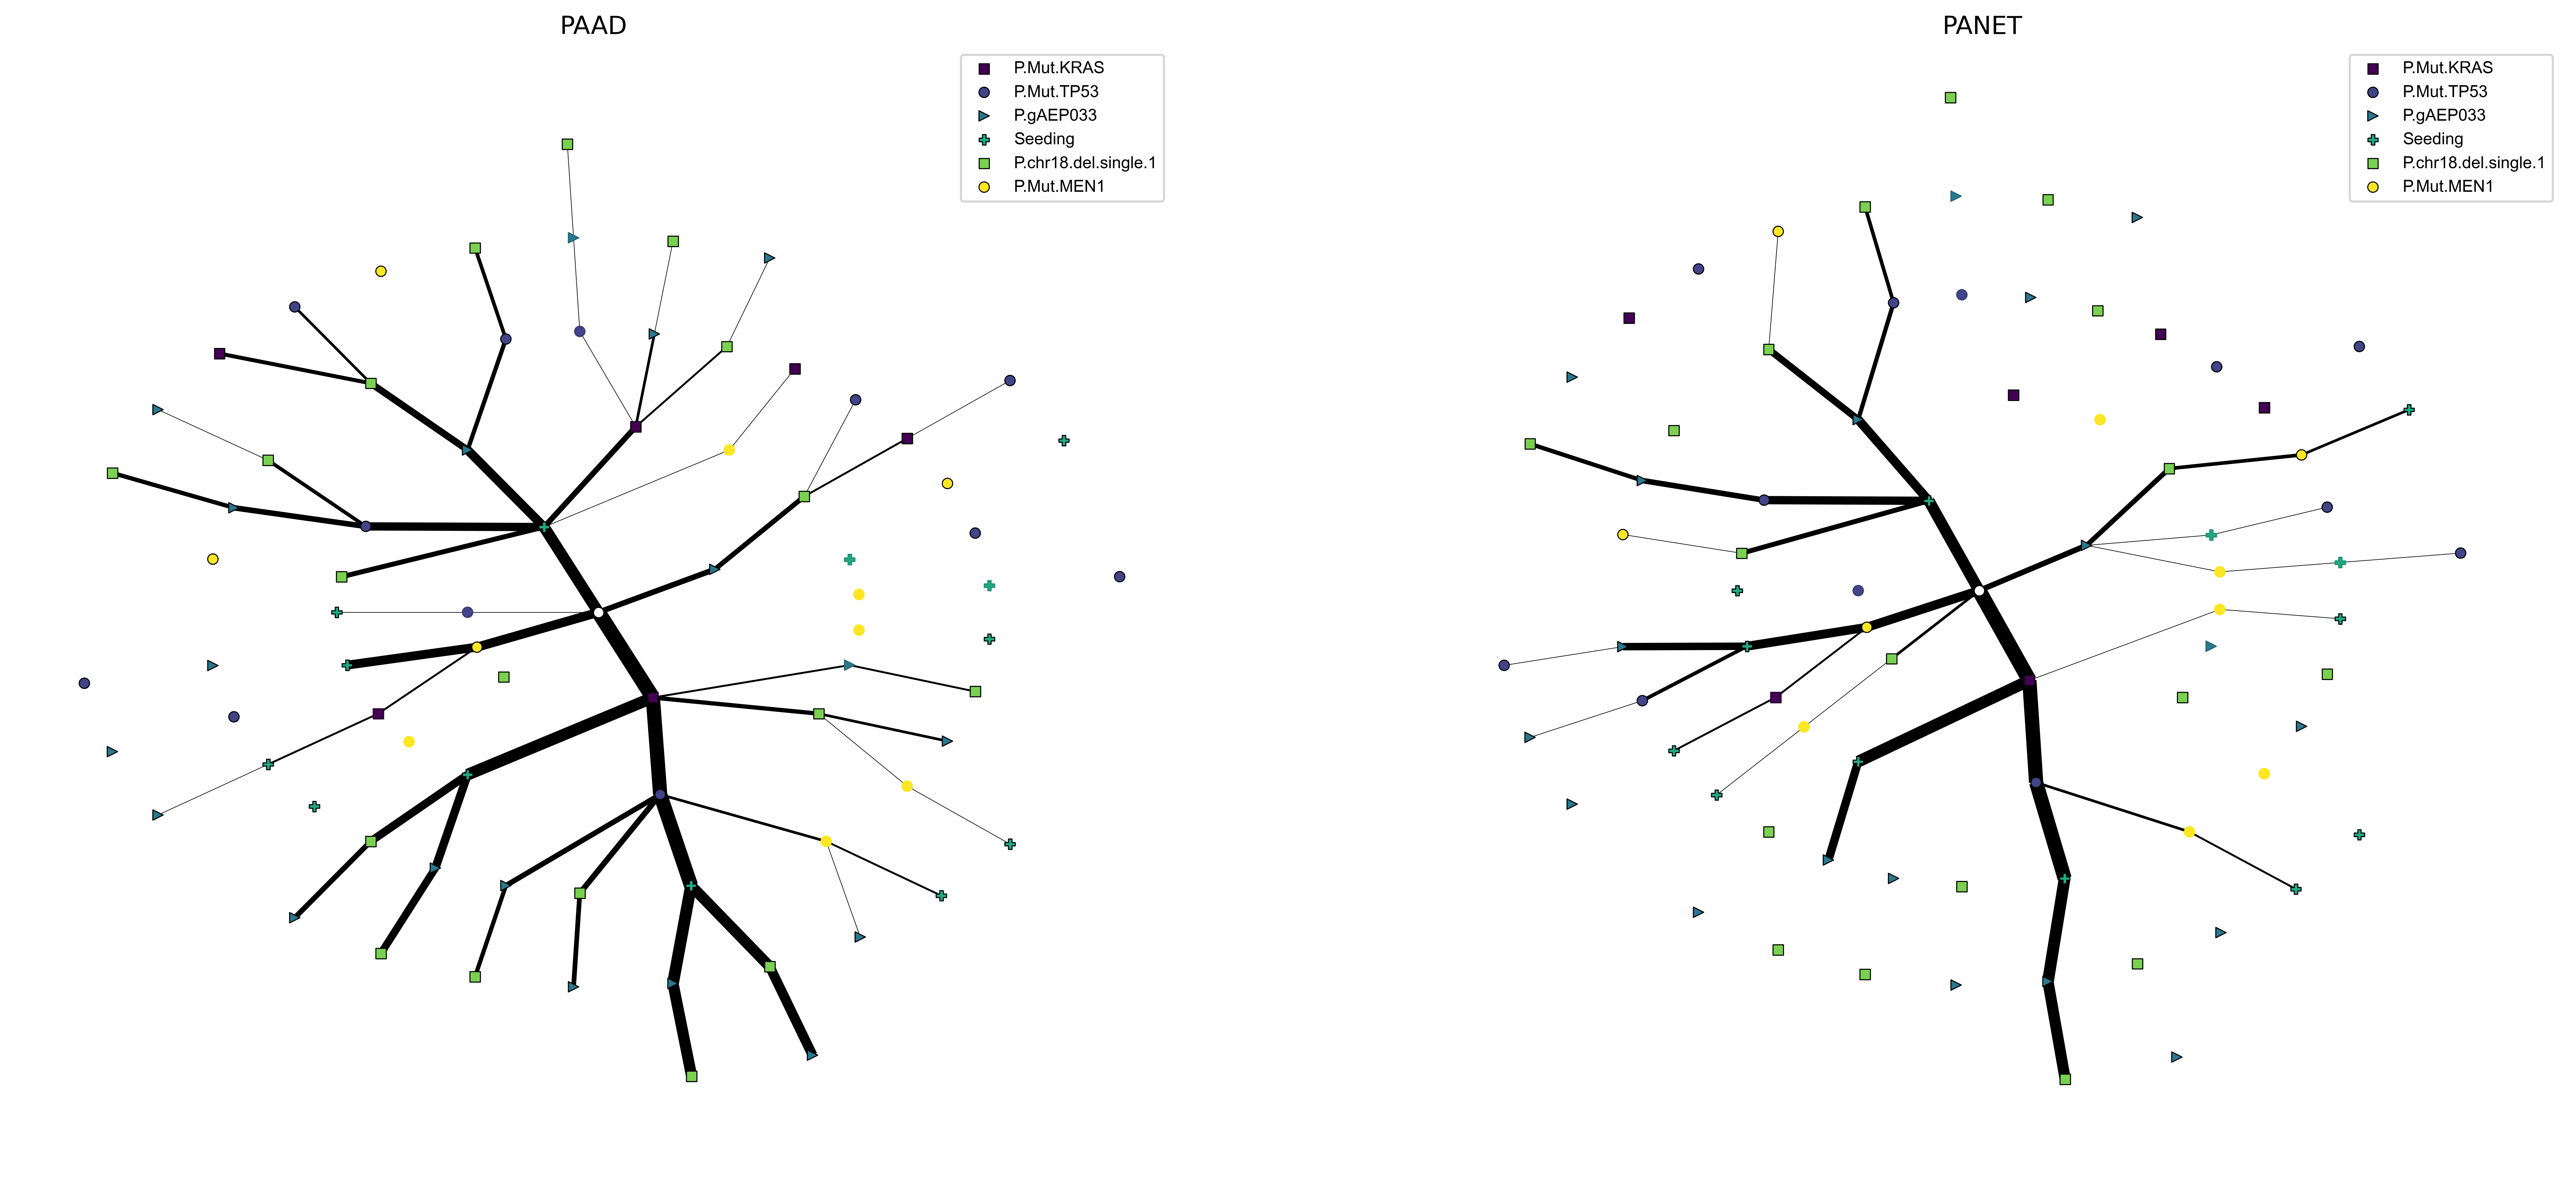

In [9]:
paad_orders = met_orders_paad + pt_orders_paad
panet_orders = met_orders_panet + pt_orders_panet 

paad_orders_filtered = [tuple(event for event in o if event in filtered_events)
             for o in paad_orders]
paad_orders_filtered = [o for o in paad_orders_filtered if not o == ()]
panet_orders_filtered = [tuple(event for event in o if event in filtered_events)
             for o in panet_orders]
panet_orders_filtered = [o for o in panet_orders_filtered if not o == ()]

g_paad = metMHN.history_tree(paad_orders_filtered)
g_panet = metMHN.history_tree(panet_orders_filtered)


f, axis = plt.subplots(1,2)


nx.draw_networkx_edges(g, pos,
                       edgelist=list(g_paad.edges),
                       width=[
                           0.9 * np.log(g.edges[(e1, e2)]["weight"]) + 0.3 for e1, e2 in g_paad.edges],
                       # width=0.5,
                       ax=axis[0],
                       )

for obs in g.graph["observations"]:
    nx.draw_networkx_nodes(g, pos, nodelist=node_dict[obs],
                           node_size=node_size,
                           label=legend_alias.get(
        obs, str(obs)[:min(20, len(str(obs)))]),
        node_shape=markers[obs],
        node_color=[colors[obs]],
        edgecolors=["black" if g.nodes[n].get("terminal") else
                    # "silver"
                    lighten_color(colors[obs], 1.1)
                    for n in node_dict[obs]]
        if not always_contour else "black",
        linewidths=contour_width,
        ax=axis[0])
if root == ():
    nx.draw_networkx_nodes(
        g,
        pos,
        nodelist=[()],
        node_size=node_size,
        node_color="white", edgecolors="black", linewidths=contour_width, ax=axis[0])
axis[0].axis("off")

axis[0].legend(prop=legend_kws)

axis[0].axis("off")
axis[0].set_title("PAAD")




nx.draw_networkx_edges(g, pos,
                       edgelist=list(g_panet.edges),
                       width=[
                           0.9 * np.log(g.edges[(e1, e2)]["weight"]) + 0.3 for e1, e2 in g_panet.edges],
                       # width=0.5,
                       ax=axis[1],
                       )

for obs in g.graph["observations"]:
    nx.draw_networkx_nodes(g, pos, nodelist=node_dict[obs],
                           node_size=node_size,
                           label=legend_alias.get(
        obs, str(obs)[:min(20, len(str(obs)))]),
        node_shape=markers[obs],
        node_color=[colors[obs]],
        edgecolors=["black" if g.nodes[n].get("terminal") else
                    # "silver"
                    lighten_color(colors[obs], 1.1)
                    for n in node_dict[obs]]
        if not always_contour else "black",
        linewidths=contour_width,
        ax=axis[1])
if root == ():
    nx.draw_networkx_nodes(
        g,
        pos,
        nodelist=[()],
        node_size=node_size,
        node_color="white", edgecolors="black", linewidths=contour_width, ax=axis[1])
axis[1].axis("off")

axis[1].legend(prop=legend_kws)

axis[1].axis("off")
axis[1].set_title("PANET")




f.set_dpi(500)
f.set_size_inches(22, 10)


#### Data for Johnston plots

In [11]:
pt_positions = np.zeros((pts.shape[1], pts.sum(axis=1).max()), dtype=int)
for order in pt_orders:
    for i, e in enumerate(order):
        pt_positions[e, i] += 1
met_positions = np.zeros((mets_t1.shape[1], mets_t1.sum(axis=1).max()), dtype=int)
for order in met_orders:
    for i, e in enumerate(order):
        met_positions[e, i] += 1


In [12]:
pt_positions_seeded = np.zeros((pts.shape[1], pts.sum(axis=1).max()), dtype=int)
for order in pt_orders:
    if not n in order:
        continue
    order = order[order.index(n) + 1:]
    for i, e in enumerate(order):
        pt_positions_seeded[e, i] += 1
met_positions_seeded = np.zeros((mets_t1.shape[1], mets_t1.sum(axis=1).max()), dtype=int)
for order in met_orders:
    if not n in order:
        continue
    order = order[order.index(n) + 1:]
    for i, e in enumerate(order):
        met_positions_seeded[e, i] += 1


In [13]:
np.savetxt(f"{log_theta_file}_met_positions.csv", met_positions, delimiter=",")

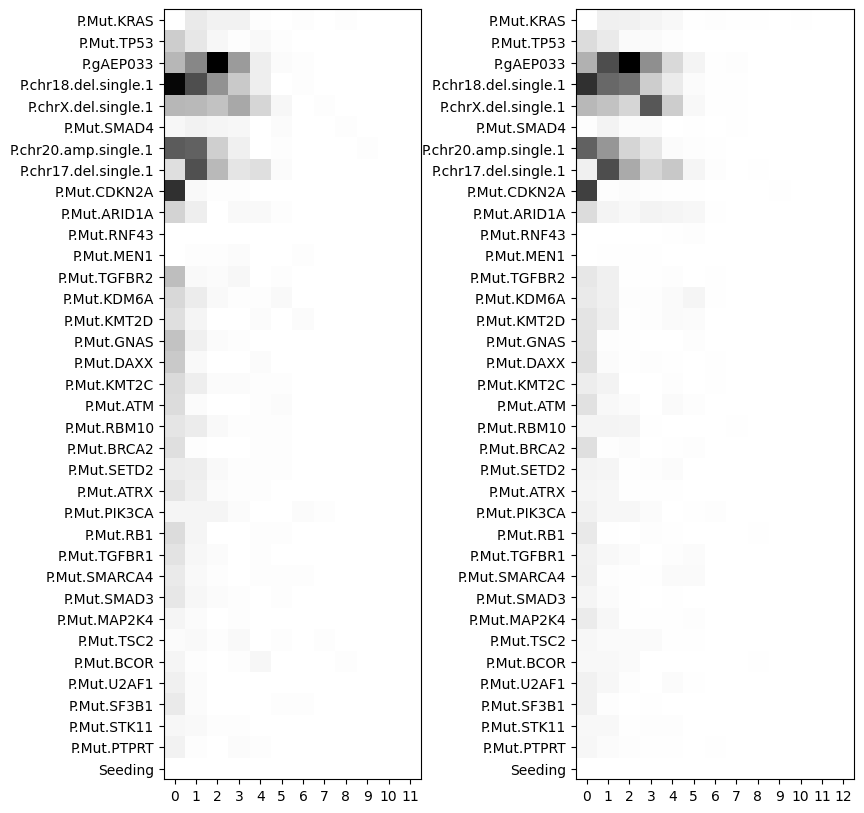

In [14]:
f, a = plt.subplots(ncols=2, figsize=(10,10))

a[0].imshow(pt_positions_seeded, cmap="gist_yarg")
_ = a[0].set_yticks(range(n+1))
_ = a[0].set_xticks(range(pts.sum(axis=1).max()))
_ = a[0].set_yticklabels(pts.columns)
a[1].imshow(met_positions_seeded, cmap="gist_yarg")
_ = a[1].set_yticks(range(n+1))
_ = a[1].set_xticks(range(mets_t1.sum(axis=1).max()))
_ = a[1].set_yticklabels(pts.columns)

In [18]:
paad_pt_positions = np.zeros((pts.shape[1], pts.sum(axis=1).max()), dtype=int)
for order in pt_orders_paad:
    for i, e in enumerate(order):
        paad_pt_positions[e, i] += 1
paad_met_positions = np.zeros((mets_t1.shape[1], mets_t1.sum(axis=1).max()), dtype=int)
for order in met_orders_paad:
    for i, e in enumerate(order):
        paad_met_positions[e, i] += 1
panet_pt_positions = np.zeros((pts.shape[1], pts.sum(axis=1).max()), dtype=int)
for order in pt_orders_panet:
    for i, e in enumerate(order):
        panet_pt_positions[e, i] += 1
panet_met_positions = np.zeros((mets_t1.shape[1], mets_t1.sum(axis=1).max()), dtype=int)
for order in met_orders_panet:
    for i, e in enumerate(order):
        panet_met_positions[e, i] += 1


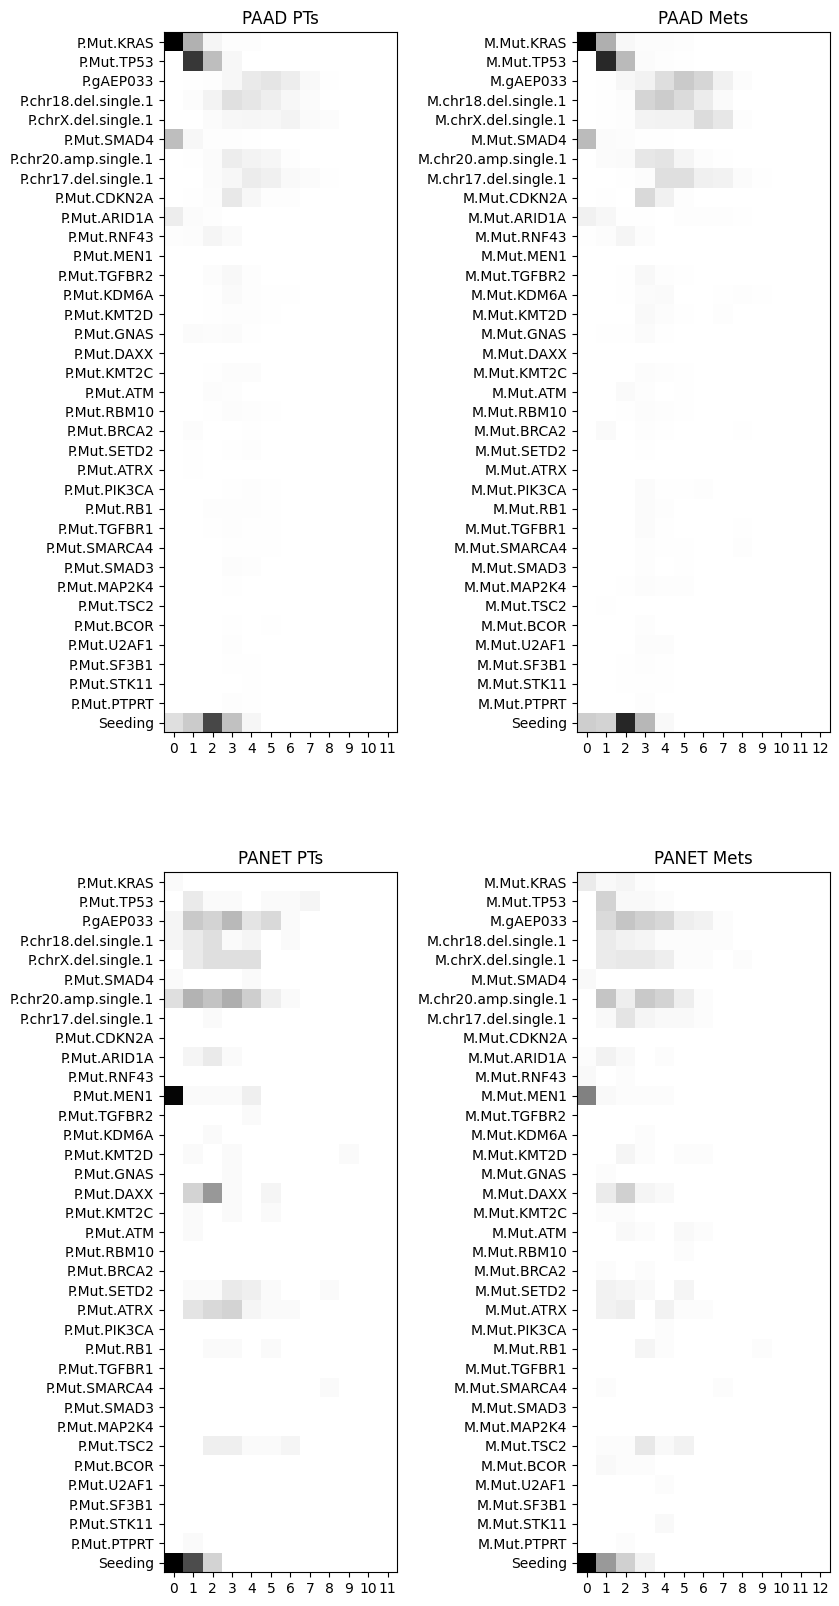

In [19]:
f, a = plt.subplots(ncols=2, nrows=2, figsize=(10,20))

# PAAD PTs
a[0][0].imshow(paad_pt_positions, cmap="gist_yarg")
_ = a[0][0].set_yticks(range(n+1))
_ = a[0][0].set_xticks(range(pts.sum(axis=1).max()))
_ = a[0][0].set_yticklabels(pts.columns)
_ = a[0, 0].set_title("PAAD PTs")
# PAAD Mets
a[0][1].imshow(paad_met_positions, cmap="gist_yarg")
_ = a[0][1].set_yticks(range(n+1))
_ = a[0][1].set_xticks(range(mets_t1.sum(axis=1).max()))
_ = a[0][1].set_yticklabels(mets_t1.columns)
_ = a[0, 1].set_title("PAAD Mets")
# PANET PTs
a[1][0].imshow(panet_pt_positions, cmap="gist_yarg")
_ = a[1][0].set_yticks(range(n+1))
_ = a[1][0].set_xticks(range(pts.sum(axis=1).max()))
_ = a[1][0].set_yticklabels(pts.columns)
_ = a[1, 0].set_title("PANET PTs")
#PAAD Mets
a[1][1].imshow(panet_met_positions, cmap="gist_yarg")
_ = a[1][1].set_yticks(range(n+1))
_ = a[1][1].set_xticks(range(mets_t1.sum(axis=1).max()))
_ = a[1][1].set_yticklabels(mets_t1.columns)
_ = a[1, 1].set_title("PANET Mets")

f.savefig("temp.png", bbox_inches="tight", dpi=300)

In [20]:
np.savetxt(f"{log_theta_file}_paad_pt_positions.csv", paad_pt_positions, delimiter=",")
np.savetxt(f"{log_theta_file}_paad_met_positions.csv", paad_met_positions, delimiter=",")
np.savetxt(f"{log_theta_file}_panet_pt_positions.csv", panet_pt_positions, delimiter=",")
np.savetxt(f"{log_theta_file}_panet_met_positions.csv", panet_met_positions, delimiter=",")